In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert RGB to grayscale (1 channel)
    transforms.ToTensor(),  # Convert to tensor (values between 0 and 1)
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0, variance 1
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders for batching and shuffling
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

# Check shape of an image
sample_image, sample_label = trainset[0]
print("Image shape:", sample_image.shape)  # Expected: (1, 32, 32)


100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Image shape: torch.Size([1, 32, 32])


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Define transformations: Convert to grayscale & normalize
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Custom Dataset to convert images to 1D sequences for S4
class sCIFAR10Dataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        # Flatten image from (1, 32, 32) → (1024,)
        img = img.view(-1, 1)  # Convert to (1024, 1) for S4 input

        return img, label

# Convert dataset for S4 model
train_dataset = sCIFAR10Dataset(trainset)
test_dataset = sCIFAR10Dataset(testset)

# Create DataLoaders
trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Check shape
sample_image, sample_label = train_dataset[0]
print("Image shape:", sample_image.shape)  # Expected: (1024, 1)


Files already downloaded and verified
Files already downloaded and verified
Image shape: torch.Size([1024, 1])


In [ ]:
!pip  install opt_einsum

In [ ]:
for images, labels in trainloader:
    images = images.squeeze(-1).to(device)  # Fix shape here
    labels = labels.to(device)


KeyboardInterrupt: 

In [ ]:
pip install

In [ ]:
import torch
import torch.nn as nn

class SimpleS4Layer(nn.Module):
    def __init__(self, input_dim, state_dim):
        super().__init__()
        # Learnable parameters for the state-space model
        self.A = nn.Parameter(torch.randn(state_dim, state_dim) * 0.1)  # State transition matrix (A)
        self.B = nn.Parameter(torch.randn(state_dim, input_dim) * 0.1)  # Input matrix (B)
        self.C = nn.Parameter(torch.randn(1, state_dim) * 0.1)          # Output matrix (C)
        # Optionally, you could add a bias term (D) if needed

    def forward(self, x):
        """
        Forward pass through the S4 layer.

        Args:
            x (Tensor): Input tensor with shape (batch_size, seq_len, input_dim)

        Returns:
            outputs (Tensor): Output tensor with shape (batch_size, seq_len, 1)

        The state-space equations in discrete time can be written as:
            h_{t+1} = tanh( h_t @ A^T + u_t @ B^T )
            y_t   = h_t @ C^T
        where:
            - h_t is the hidden state at time t.
            - u_t (here x[:, t]) is the input at time t.
        """
        batch_size, seq_len, input_dim = x.squeeze(-1).shape

        # Initialize hidden state h with zeros for each sample in the batch.
        # h has shape: (batch_size, state_dim)
        h = torch.zeros(batch_size, self.A.shape[0], device=x.device)

        outputs = []
        for t in range(seq_len):
            # Extract the input at time t. Its shape will be (batch_size, input_dim).
            xt = x[:, t]

            # Compute the state update.
            # h @ A^T: (batch_size, state_dim) @ (state_dim, state_dim) = (batch_size, state_dim)
            # xt @ B^T: (batch_size, input_dim) @ (input_dim, state_dim) = (batch_size, state_dim)
            # Then apply tanh for non-linearity.
            h = torch.tanh(torch.matmul(h, self.A.t()) + torch.matmul(xt, self.B.t()))

            # Compute the output for time t.
            # h @ C^T: (batch_size, state_dim) @ (state_dim, 1) = (batch_size, 1)
            y = torch.matmul(h, self.C.t())
            outputs.append(y)

        # Concatenate the outputs along the time dimension.
        # Final shape: (batch_size, seq_len, 1)
        outputs = torch.cat(outputs, dim=1)
        return outputs


In [ ]:
class S4Classifier(nn.Module):
    def __init__(self, input_dim=1, state_dim=64, num_classes=10):
        super().__init__()
        self.s4 = SimpleS4Layer(input_dim, state_dim)
        self.fc = nn.Linear(1024, num_classes)  # Map sequence output to 10 classes

    def forward(self, x):
        x = x.unsqueeze(-1)  # Ensure (batch_size, seq_len, input_dim=1)
        x = self.s4(x)
        x = torch.mean(x, dim=1)  # Pooling
        return self.fc(x)



In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = S4Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")



RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 1024x10)

In [ ]:
ls /content/long-range-arena/lra_benchmarks/image/


configs/  __init__.py  input_pipeline.py  __pycache__/  task_registry.py  train.py


In [ ]:
import sys
sys.path.append("/content/long-range-arena")  # Change path based on your directory


In [ ]:
from lra_benchmarks.image.input_pipeline import get_cifar10_datasets
# Load the dataset
train_dataset, val_dataset, test_dataset, num_classes, batch_size, img_shape = get_cifar10_datasets(
    n_devices=1, batch_size=64, normalize=True
)

print("Dataset loaded successfully!")

Dataset loaded successfully!


In [ ]:
batch = next(iter(train_dataset.batch(6)))  # Get a batch of 6 images

print("Batch keys:", batch.keys())  # Should print: dict_keys(['inputs', 'targets'])
print("Batch inputs shape:", batch['inputs'].shape)  # Expected: (6, 32, 32, 1)
print("Batch targets shape:", batch['targets'].shape)  # Expected: (6,)


Batch keys: dict_keys(['inputs', 'targets'])
Batch inputs shape: (6, 64, 32, 32, 1)
Batch targets shape: (6, 64)


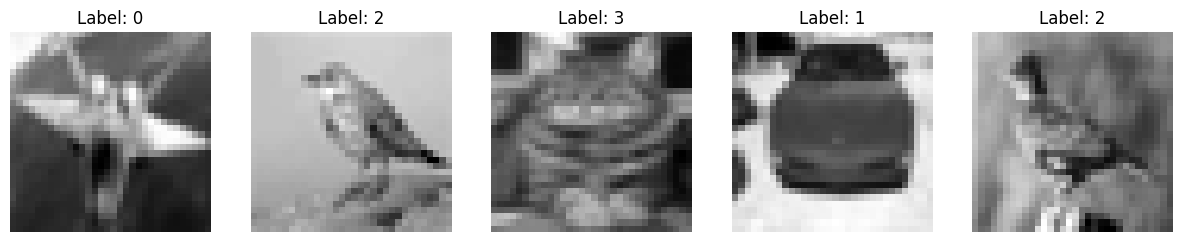

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Get ONE batch with 5 images
batch = next(iter(train_dataset.batch(5)))  # Get a batch of 5 images

# Create a figure with 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # 1 row, 5 columns

# Loop through the first 5 images
for i in range(5):
    image = batch['inputs'].numpy()[0, i]  # Select i-th image
    label = batch['targets'].numpy()[0, i]  # Select i-th label

    # Remove extra channel if necessary
    image = image.squeeze(-1)  # Convert (32, 32, 1) → (32, 32)

    # Display the image
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

plt.show()


In [ ]:
# Check the shape of the dataset
for batch in train_dataset.take(1):
    print("Inputs shape:", batch['inputs'].shape)
    print("Targets shape:", batch['targets'].shape)

print(type(train_dataset))

Inputs shape: (64, 32, 32, 1)
Targets shape: (64,)
<class 'tensorflow.python.data.ops.shuffle_op._ShuffleDataset'>


In [ ]:
# Step 1: Load the CIFAR-10 dataset
from lra_benchmarks.image.input_pipeline import get_cifar10_datasets

train_dataset, val_dataset, test_dataset, num_classes, batch_size, img_shape = get_cifar10_datasets(
    n_devices=1, batch_size=64, normalize=True
)

# Step 2: Inspect the TensorFlow dataset (before conversion)
print("Inspecting TensorFlow dataset (before conversion):")

# Take one batch from the dataset
for batch in train_dataset.take(1):
    print("Batch keys:", batch.keys())  # Should print: dict_keys(['inputs', 'targets'])
    print("Batch inputs shape:", batch['inputs'].shape)  # Expected: (batch_size, 32, 32, 1)
    print("Batch targets shape:", batch['targets'].shape)  # Expected: (batch_size,)
    print("First image in batch:", batch['inputs'][0])  # Print the first image
    print("First label in batch:", batch['targets'][0])  # Print the first label

# Step 3: Extract all images and labels
import numpy as np

def extract_full_dataset(tf_dataset):
    images = []
    labels = []
    for batch in tf_dataset:
        images.append(batch['inputs'].numpy())  # Extract all images
        labels.append(batch['targets'].numpy())  # Extract all labels
    # Concatenate all batches
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    return images, labels

# Extract all images and labels from the training dataset
train_images, train_labels = extract_full_dataset(train_dataset)
val_images, val_labels = extract_full_dataset(val_dataset)
test_images, test_labels = extract_full_dataset(test_dataset)

# Print shapes for verification
print("\nExtracted full dataset (before conversion):")
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

# Step 4: Convert to PyTorch dataset (after conversion)
import torch
from torch.utils.data import Dataset, DataLoader

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

# Create PyTorch datasets
train_pytorch_dataset = CIFAR10Dataset(train_images, train_labels)
val_pytorch_dataset = CIFAR10Dataset(val_images, val_labels)
test_pytorch_dataset = CIFAR10Dataset(test_images, test_labels)

# Step 5: Verify the PyTorch dataset
print("\nInspecting PyTorch dataset (after conversion):")
print("Train dataset length:", len(train_pytorch_dataset))
print("Validation dataset length:", len(val_pytorch_dataset))
print("Test dataset length:", len(test_pytorch_dataset))

# Check the first image and label in the training dataset
image, label = train_pytorch_dataset[0]
print("\nFirst image in PyTorch training dataset:")
print("Image shape:", image.shape)
print("Label:", label)

# Step 6: Plot the first few images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    image, label = train_pytorch_dataset[i]
    image = image.squeeze()  # Remove the channel dimension for plotting
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
plt.show()

Inspecting TensorFlow dataset (before conversion):
Batch keys: dict_keys(['inputs', 'targets'])
Batch inputs shape: (64, 32, 32, 1)
Batch targets shape: (64,)
First image in batch: tf.Tensor(
[[[0.45490196]
  [0.49803922]
  [0.53333333]
  ...
  [0.69411765]
  [0.81960784]
  [0.92156863]]

 [[0.42352941]
  [0.45490196]
  [0.45098039]
  ...
  [0.56470588]
  [0.61960784]
  [0.8       ]]

 [[0.45882353]
  [0.50980392]
  [0.5372549 ]
  ...
  [0.51764706]
  [0.59215686]
  [0.70588235]]

 ...

 [[0.60784314]
  [0.53333333]
  [0.35294118]
  ...
  [0.6       ]
  [0.60392157]
  [0.6       ]]

 [[0.33333333]
  [0.28235294]
  [0.2627451 ]
  ...
  [0.6627451 ]
  [0.61568627]
  [0.62745098]]

 [[0.33333333]
  [0.29411765]
  [0.28627451]
  ...
  [0.65490196]
  [0.6745098 ]
  [0.63921569]]], shape=(32, 32, 1), dtype=float64)
First label in batch: tf.Tensor(9, shape=(), dtype=int64)


KeyboardInterrupt: 

Train images shape: (2, 32, 32, 1)
Train labels shape: (2,)


Batch keys: dict_keys(['inputs', 'targets'])
Batch inputs shape: (2, 32, 32, 1)
Batch targets shape: (2,)


Batch images shape: torch.Size([2, 32, 32, 1])
Batch labels shape: torch.Size([2])


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Create a PyTorch Dataset
class SmallCIFAR10Dataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

# Create PyTorch dataset
small_pytorch_dataset = SmallCIFAR10Dataset(train_images, train_labels)

AttributeError: 'SmallCIFAR10Dataset' object has no attribute 'take'